In [2]:
import math
import numpy as np
import scipy.stats as sct
from scipy.optimize import minimize

from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import geom

from matplotlib import pyplot as plt

$X$ represents the total cash received after liquidating the portfolio, which contains an allocation to the risk free asset and an allocation to the risky asset (ETF), net of any associated transaction costs.

Using initial portfolio allocations (in shares) at $t=0$, $\theta(0)$ and $\phi(0)$, we model $X$ similar to that of our initial outlay $b$, except we need to deduct the total transaction costs from our cash receipt (as compared to added into $b$, as in our total cash outlay)

Thus $X = g(\cdot) = \theta(0) \cdot F(1) + \phi(0)\cdot S(1) - \phi(0)^2 \cdot \rho \cdot S(1)$

where $\theta(0)$, $\phi(0)$, $F(1)$, and $S(1)$ are parameters in the function with transaction costs $\rho \in (0,1)$

A test run of asset pricing and optimization routine is below:

In [3]:
#sample model assumptions

F0 = 1
S0 = 2
p = 0.4
mu0 = 0.1
sigma0 = 0.15
mu1 = 0.25
sigma1 = 0.3
rho = 0.01
r = 0.03
b = 200

Sample generation of RVs and respective asset prices at time $t=1$


In [4]:
#sample calcs for RVs and S(1), F(1)

r_star = 1 - pow(2, -1.5) 
N = np.random.geometric(p = r_star)

N = 1 #for now, will need to remove this when doing legit monte carlo

J = bernoulli.rvs(p, size=N)
Z = norm.rvs(0, 1, size=N)
R = np.exp((mu0 + Z*sigma0*J) + (mu1 + Z*sigma1*(1-J)))

S1 = S0*R
F1 = np.tile(np.exp(r)*F0,N)
print('Risk Free Asset: ', F1, '\nRisky Asset: ', S1)

Risk Free Asset:  [1.03045453] 
Risky Asset:  [2.37811044]


In [5]:
#sample objective functions

def u(x):
    return -1*np.log(max(0,(x[0]*F1 + x[1]*S1 - (x[1]**2)*rho*S1)))

Need to set bounds for optimization above 0 so the logarithm aspect of the utility function $u(x) = log(max(0,X))$ doesn't break during the optimization routine.

Thus, short positions are not possible.

In [6]:
#bounds

bnds = ((.000001, np.inf), (.000001, np.inf))

The only constraint in this problem is that the initial cash outlay $b = 200$, so we set up an equality constraint below

In [7]:
#constraints

def cons1(x):
    return 1*(x[0]*F0 + x[1]*S0 + (x[1]**2)*rho*S0 - 200)
cons = ({'type':'eq', 'fun': cons1})

Finally, the optimization routine

In [8]:
#non-linear optimization

res = minimize(u, [0,0], method='SLSQP', bounds = bnds, constraints = cons)
res

     fun: -5.279811189928385
     jac: array([-0.00524849, -0.0075525 ])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([155.26565003,  18.82381492])

In [9]:
#constraint check

print('Initial cash outlay b = 200? ',np.isclose(round(cons1(res.x),4),0))

Initial cash outlay b = 200?  True


In [10]:
#maximum utility

-u(res.x)

array([5.27981119])

In [11]:
def opt(N, S0, n0, p, mu0, sigma0, mu1, sigma1, rho, r, b):
    obj, opt = np.zeros(pow(2,N+n0+1)), np.zeros(pow(2,N+n0+1))
        
    J = bernoulli.rvs(p, size=pow(2,N+n0+1))
    Z = norm.rvs(0, 1, size=pow(2,N+n0+1))
    R = np.exp((mu0 + Z*sigma0*J) + (mu1 + Z*sigma1*(1-J)))
    
    F0 = 1
    S1 = S0*R
    F1 = np.tile(np.exp(r)*F0,pow(2,N+n0+1))
    
    for i in range(len(obj)):
        def u(x):
            return -1*np.log(max(0,(x[0]*F1[i] + x[1]*S1[i] - (x[1]**2)*rho*S1[i])))
        def cons1(x):
            return 1*(x[0]*F0 + x[1]*S0 + (x[1]**2)*rho*S0 - b)
        cons = ({'type':'eq', 'fun': cons1})
        bnds = ((.000001, np.inf), (.000001, np.inf))
    
        res = minimize(u, [0,0], method='SLSQP', bounds = bnds, constraints = cons)
        obj[i] = -u(res.x)
        opt[i] = res.x[1]
    return obj, opt

In [18]:
def Q2(S0, p, mu0, sigma0, mu1, sigma1, rho, r, b, gamma, delta, n0, N0):
    burn_in = n0
    num_sample = N0
    z = sct.norm.ppf(1 - delta/2) # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow(2, -1.5) # optimal success rate for the geometric of N

    obj_confidence_interval = float('inf')
    opt_confidence_interval = float('inf')
    obj_running_mean = 0
    opt_running_mean = 0
    obj_running_2moment = 0
    opt_running_2moment = 0

    num_estimator = 0 #count of number of estimators generated
    CIs1 = np.zeros((1, num_sample))
    CIs2 = np.zeros((1, num_sample))
    obj_estimation = np.zeros((1, num_sample))
    opt_estimation = np.zeros((1, num_sample))

    while (num_estimator < num_sample or (obj_confidence_interval >= delta and opt_confidence_interval >= delta)):
        N = np.random.geometric(p=r_star)
        obj_samples, opt_samples = opt(N, S0, n0, p, mu0, sigma0, mu1, sigma1, rho, r, b)
    
        obj_samples_odd = obj_samples[0::2]
        obj_samples_even = obj_samples[1::2]
        obj_samples_n_0 = obj_samples[0:pow(2,n0)]
    
        obj_theta_N = np.mean(obj_samples)
        obj_theta_N_odd = np.mean(obj_samples_odd)
        obj_theta_N_even = np.mean(obj_samples_even)
        obj_theta_n_0 = np.mean(obj_samples_n_0)
    
        opt_samples_odd = opt_samples[0::2]
        opt_samples_even = opt_samples[1::2]
        opt_samples_n_0 = opt_samples[0:pow(2,n0)]
    
        opt_theta_N = np.mean(opt_samples)
        opt_theta_N_odd = np.mean(opt_samples_odd)
        opt_theta_N_even = np.mean(opt_samples_even)
        opt_theta_n_0 = np.mean(opt_samples_n_0)
    
        obj_X_star = (obj_theta_N - (obj_theta_N_odd + obj_theta_N_even) / 2) / sct.geom(r_star).pmf(N+1) + obj_theta_n_0
        opt_X_star = (opt_theta_N - (opt_theta_N_odd + opt_theta_N_even) / 2) / sct.geom(r_star).pmf(N+1) + opt_theta_n_0
    
        obj_running_mean = (obj_running_mean * num_estimator + obj_X_star) / (num_estimator + 1)
        opt_running_mean = (opt_running_mean * num_estimator + opt_X_star) / (num_estimator + 1)
    
        obj_running_2moment = (obj_running_2moment * num_estimator + pow(obj_X_star, 2)) / (num_estimator + 1)
        opt_running_2moment = (opt_running_2moment * num_estimator + pow(opt_X_star, 2)) / (num_estimator + 1)
    
        obj_sample_std = math.sqrt(obj_running_2moment - pow(obj_running_mean, 2))
        opt_sample_std = math.sqrt(opt_running_2moment - pow(opt_running_mean, 2))
    
        num_estimator = num_estimator + 1
    
        obj_confidence_interval = z * obj_sample_std / (math.sqrt(num_estimator))
        opt_confidence_interval = z * opt_sample_std / (math.sqrt(num_estimator))
    
        obj_estimation[:,num_estimator-1] = obj_running_mean
        opt_estimation[:,num_estimator-1] = opt_running_mean
    
        CIs1[:,num_estimator-1] = obj_confidence_interval
        CIs2[:,num_estimator-1] = opt_confidence_interval
    
    obj_lower = obj_estimation - CIs1
    opt_lower = opt_estimation - CIs2
    
    obj_upper = obj_estimation + CIs1
    opt_upper = opt_estimation + CIs2
    
    print('Generate', num_estimator , 'samples \n')
    
    fig, (ax1, ax2) = plt.subplots(2)
                                                                        
    n_range = np.arange(burn_in-1, num_sample)
    ax1.plot(n_range, obj_estimation[0,n_range], label='objective function estimation')
    ax1.plot(n_range, obj_lower[0,n_range], label='lower CI')
    ax1.plot(n_range, obj_upper[0,n_range], label='upper CI')
    
    ax2.plot(n_range, opt_estimation[0,n_range], label='optimal parameter estimation')
    ax2.plot(n_range, opt_lower[0,n_range], label='lower CI')
    ax2.plot(n_range, opt_upper[0,n_range], label='upper CI')
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower right')
    plt.show()
    return obj_running_mean, obj_confidence_interval, opt_running_mean, opt_confidence_interval

C:\Users\U399614\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Generate 10000 samples 



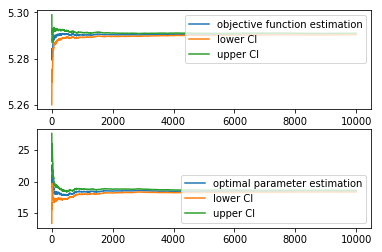

In [19]:
obj_exp, obj_CI, opt_exp, opt_CI = Q2(2, .4, .1, .15, .25, .3, .01, .03, 200, .05, .05, 2, 10000)

In [20]:
#2a

print('Optimal Parameter Confidence Interval: ',[opt_exp-opt_CI, opt_exp+opt_CI])

Optimal Parameter Confidence Interval:  [18.334566990833785, 18.60341453322456]


2b)

To begin, we generate our $N$ amount of samples using a geometric distribution. Then we generate the values of the assets at $t=1$ and loop through each sample in order to obtain the samples of our estimator. In this case, it is the maximum value achieved by a non-linear optimization routine that we need to use in order to solve for the maximum value of $E[u(x)]$ subject to the constraint that the total cost is equal to $b = 200$.

In order to obtain an unbiased estimator for our utility function $u(x)$, I used a randomized multi-level monte carlo procedure. This was necessary because of what we are trying to estimate, which is an expectation of a function of RVs. Without using MLMC, we would be introducing bias into our estimator per Jensen's inequality. Using a 5% error threshold, I computed the confidence interval of the estimator with 95% confidence.

In [21]:
#2b

print('Objective Function Confidence Interval: ',[obj_exp-obj_CI, obj_exp+obj_CI])

Objective Function Confidence Interval:  [5.2902601555223265, 5.290917610086413]


In [22]:
#2c

riskless = 200- opt_exp*2 + (opt_exp**2)*rho*2
risky = opt_exp

In [23]:
def sampler(riskless, risky, N, S0, n0, p, mu0, sigma0, mu1, sigma1, rho, r, b):
    obj = np.zeros(pow(2,N+n0+1))
        
    J = bernoulli.rvs(p, size=pow(2,N+n0+1))
    Z = norm.rvs(0, 1, size=pow(2,N+n0+1))
    R = np.exp((mu0 + Z*sigma0*J) + (mu1 + Z*sigma1*(1-J)))
    
    F0 = 1
    S1 = S0*R
    F1 = np.tile(np.exp(r)*F0,pow(2,N+n0+1))
    
    for i in range(len(obj)):
        obj[i] = max(0,b-(riskless*F1[i] + risky*S1[i] - (risky**2)*rho*S1[i]))
    
    return obj

In [24]:
def other_Q2(S0, p, mu0, sigma0, mu1, sigma1, rho, r, b, gamma, delta, n0, N0):

    burn_in = n0
    num_sample = N0
    
    z = sct.norm.ppf(1 - delta/2) # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow(2, -1.5) # optimal success rate for the geometric of N
    
    confidence_interval = float('inf')
    running_mean = 0
    running_2moment = 0
    num_estimator = 0 #count of number of estimators generated
    
    CIs = np.zeros((1, num_sample))
    estimation = np.zeros((1, num_sample))
    
    while (num_estimator < num_sample or confidence_interval >= delta):
        N = np.random.geometric(p=r_star)
        samples = sampler(riskless, risky, N, S0, n0, p, mu0, sigma0, mu1, sigma1, rho, r, b)
        samples_odd = samples[0::2]
        samples_even = samples[1::2]
        samples_n_0 = samples[0:pow(2,n0)]
        
        theta_N = np.mean(samples)
        theta_N_odd = np.mean(samples_odd)
        theta_N_even = np.mean(samples_even)
        theta_n_0 = np.mean(samples_n_0)
        
        X_star = (theta_N - (theta_N_odd + theta_N_even) / 2) / sct.geom(r_star).pmf(N+1) + theta_n_0
        running_mean = (running_mean * num_estimator + X_star) / (num_estimator + 1)
        running_2moment = (running_2moment * num_estimator + pow(X_star, 2)) / (num_estimator + 1)
       
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2))
        num_estimator = num_estimator + 1
        confidence_interval = z * sample_std / (math.sqrt(num_estimator))
        estimation[:,num_estimator-1] = running_mean
        CIs[:,num_estimator-1] = confidence_interval
        
    lower = estimation - CIs
    upper = estimation + CIs
    print('Generate', num_estimator , 'samples \n')
    
    n_range = np.arange(burn_in-1, num_sample)
    plt.plot(n_range, estimation[0,n_range], label='estimation')
    plt.plot(n_range, lower[0,n_range], label='lower CI')
    plt.plot(n_range, upper[0,n_range], label='upper CI')
    plt.legend(loc='upper right')
    plt.show()
    
    return running_mean, confidence_interval

Generate 100000 samples 



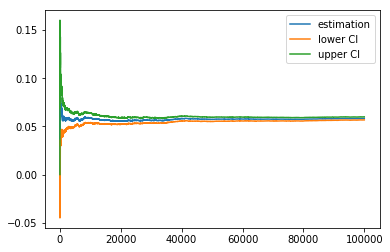

In [30]:
exp_loss, CI_loss = other_Q2(2, .4, .1, .15, .25, .3, .01, .03, 200, .05, .05, 2, 100000)

In [31]:
print('95% VaR: ',[exp_loss-CI_loss, exp_loss+CI_loss])

95% VaR:  [0.05668289192409638, 0.05984745368006911]


Our previous analysis provides us with optimal portfolio allocations for maximizing the utility function. 

What's interesting about the two different estimators is that the the maximum utility function appears to be very tightly clustered around 5.3, to the extent that even if we wanted to use a variance reduction technique, it probably wouldn't be worthwhile. That said, the optimal allocation to the risky asset is more interesting because of the wider band of values that it takes - which is anywhere from 0 to the high 40s. That's a big range!

<function matplotlib.pyplot.show(*args, **kw)>

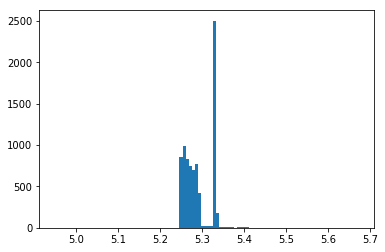

In [37]:
plt.hist(x1,bins=100)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

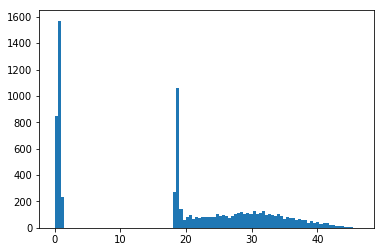

In [38]:
plt.hist(x2,bins=100)
plt.show

So basically what our above analysis is telling us is that we should take the middle of the road allocation to the risky asset; in the 18 share area.

Lets use these allocations to form control variates and expectations of optimal allocations, and hopefully we can hopefully achieve some variance reduction. 

The portfolio's allocation to the risky asset is obviously very sensitive to the allocation to the risk free asset. This makes sense - there are only two assets in the portfolio!

We can use the expected value of the risk free portion of the portfolio given an optimal allocation at time $t=0$ as a control variate.

Set $g(\cdot) = \theta(0) \cdot F(0)$ with the expectation of being the optimal riskless allocation that we computed above

In [39]:
EZ = riskless*F0

def g(Z):
    return Z*F0

print(EZ)

169.88409087130006


In [34]:
def Q3_opt(N, S0, n0, p, mu0, sigma0, mu1, sigma1, rho, r, b):
    obj, opt, GZ = np.zeros(pow(2,N+n0+1)), np.zeros(pow(2,N+n0+1)), np.zeros(pow(2,N+n0+1))
        
    J = bernoulli.rvs(p, size=pow(2,N+n0+1))
    Z = norm.rvs(0, 1, size=pow(2,N+n0+1))
    R = np.exp((mu0 + Z*sigma0*J) + (mu1 + Z*sigma1*(1-J)))
    
    F0 = 1
    S1 = S0*R
    F1 = np.tile(np.exp(r)*F0,pow(2,N+n0+1))
    
    for i in range(len(obj)):
        def u(x):
            return -1*np.log(max(0,(x[0]*F1[i] + x[1]*S1[i] - (x[1]**2)*rho*S1[i])))
        def cons1(x):
            return 1*(x[0]*F0 + x[1]*S0 + (x[1]**2)*rho*S0 - b)
        cons = ({'type':'eq', 'fun': cons1})
        bnds = ((.000001, np.inf), (.000001, np.inf))
    
        res = minimize(u, [0,0], method='SLSQP', bounds = bnds, constraints = cons)
        obj[i] = -u(res.x)
        opt[i] = res.x[1]
        GZ[i] = res.x[0]
        
    return obj, opt, GZ

In [36]:
x1, x2, y = Q3_opt(2, S0, 10, p, mu0, sigma0, mu1, sigma1, rho, r, b)

C:\Users\U399614\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [237]:
#compute betas

obj_beta = sct.pearsonr(x1,g(y))[0]
opt_beta = sct.pearsonr(x2,g(y))[0]

print('Beta of Objective function to control variate Z: ',obj_beta)
print('Beta of optimal risk asset allocation to control variate Z: ',opt_beta)

Beta of Objective function to control variate Z:  0.6990343525919201
Beta of optimal risk asset allocation to control variate Z:  -0.9967271808030959


In [238]:
def first_CV_Q3(S0, p, mu0, sigma0, mu1, sigma1, rho, r, b, gamma, delta, n0, N0):
    
    EZ = riskless*F0

    def g(Z):
        return Z*F0
    
    burn_in = n0
    num_sample = N0
    z = sct.norm.ppf(1 - delta/2) # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow(2, -1.5) # optimal success rate for the geometric of N

    obj_confidence_interval = float('inf')
    opt_confidence_interval = float('inf')
    obj_running_mean = 0
    opt_running_mean = 0
    obj_running_2moment = 0
    opt_running_2moment = 0

    num_estimator = 0 #count of number of estimators generated
    CIs1 = np.zeros((1, num_sample))
    CIs2 = np.zeros((1, num_sample))
    obj_estimation = np.zeros((1, num_sample))
    opt_estimation = np.zeros((1, num_sample))

    while (num_estimator < num_sample):
        N = np.random.geometric(p=r_star)
        obj_samples, opt_samples, Z = Q3_opt(N, S0, n0, p, mu0, sigma0, mu1, sigma1, rho, r, b)
        
        ######################
        ###CONTROL VARIATES###
        ######################
        
        opt_samples = opt_samples - (opt_beta * (g(Z) - EZ))
    
        obj_samples_odd = obj_samples[0::2]
        obj_samples_even = obj_samples[1::2]
        obj_samples_n_0 = obj_samples[0:pow(2,n0)]
    
        obj_theta_N = np.mean(obj_samples)
        obj_theta_N_odd = np.mean(obj_samples_odd)
        obj_theta_N_even = np.mean(obj_samples_even)
        obj_theta_n_0 = np.mean(obj_samples_n_0)
    
        opt_samples_odd = opt_samples[0::2]
        opt_samples_even = opt_samples[1::2]
        opt_samples_n_0 = opt_samples[0:pow(2,n0)]
    
        opt_theta_N = np.mean(opt_samples)
        opt_theta_N_odd = np.mean(opt_samples_odd)
        opt_theta_N_even = np.mean(opt_samples_even)
        opt_theta_n_0 = np.mean(opt_samples_n_0)
    
        obj_X_star = (obj_theta_N - (obj_theta_N_odd + obj_theta_N_even) / 2) / sct.geom(r_star).pmf(N+1) + obj_theta_n_0
        opt_X_star = (opt_theta_N - (opt_theta_N_odd + opt_theta_N_even) / 2) / sct.geom(r_star).pmf(N+1) + opt_theta_n_0
    
        obj_running_mean = (obj_running_mean * num_estimator + obj_X_star) / (num_estimator + 1)
        opt_running_mean = (opt_running_mean * num_estimator + opt_X_star) / (num_estimator + 1)
    
        obj_running_2moment = (obj_running_2moment * num_estimator + pow(obj_X_star, 2)) / (num_estimator + 1)
        opt_running_2moment = (opt_running_2moment * num_estimator + pow(opt_X_star, 2)) / (num_estimator + 1)
    
        obj_sample_std = math.sqrt(obj_running_2moment - pow(obj_running_mean, 2))
        opt_sample_std = math.sqrt(opt_running_2moment - pow(opt_running_mean, 2))
    
        num_estimator = num_estimator + 1
    
        obj_confidence_interval = z * obj_sample_std / (math.sqrt(num_estimator))
        opt_confidence_interval = z * opt_sample_std / (math.sqrt(num_estimator))
    
        obj_estimation[:,num_estimator-1] = obj_running_mean
        opt_estimation[:,num_estimator-1] = opt_running_mean
    
        CIs1[:,num_estimator-1] = obj_confidence_interval
        CIs2[:,num_estimator-1] = opt_confidence_interval
    
    obj_lower = obj_estimation - CIs1
    opt_lower = opt_estimation - CIs2
    
    obj_upper = obj_estimation + CIs1
    opt_upper = opt_estimation + CIs2
    
    print('Generate', num_estimator , 'samples \n')
    
    fig, (ax1, ax2) = plt.subplots(2)
                                                                        
    n_range = np.arange(burn_in-1, num_sample)
    ax1.plot(n_range, obj_estimation[0,n_range], label='objective function estimation')
    ax1.plot(n_range, obj_lower[0,n_range], label='lower CI')
    ax1.plot(n_range, obj_upper[0,n_range], label='upper CI')
    
    ax2.plot(n_range, opt_estimation[0,n_range], label='optimal parameter estimation')
    ax2.plot(n_range, opt_lower[0,n_range], label='lower CI')
    ax2.plot(n_range, opt_upper[0,n_range], label='upper CI')
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower right')
    plt.show()
    return obj_running_mean, obj_confidence_interval, opt_running_mean, opt_confidence_interval

C:\Users\U399614\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Generate 10000 samples 



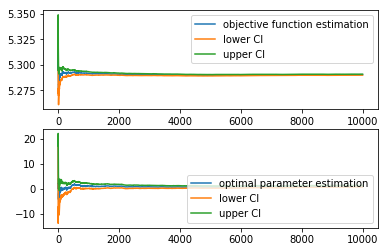

In [239]:
obj_exp, obj_CI, opt_exp, opt_CI = first_CV_Q3(2, .4, .1, .15, .25, .3, .01, .03, 200, .05, .05, 1, 10000)

In [240]:
print('Objective Function Confidence Interval: ',[obj_exp-obj_CI, obj_exp+obj_CI])

Objective Function Confidence Interval:  [5.2899502219055625, 5.290890720824737]


In [241]:
print('Optimal Parameter Confidence Interval: ',[opt_exp-opt_CI, opt_exp+opt_CI])

Optimal Parameter Confidence Interval:  [0.7723504599105809, 1.413102314539889]


In [245]:
np.log(riskless*np.exp(r)*F0)

5.1647134737372085

Wow, these results are wildly different than our initial portfolio optimization.

This basically says that we should not be allocating much, if any, of the portfolio to the risky asset.

What if set our control variate by using an expected value of the risky asset allocation at time $t=1$ instead?

Set $g(\cdot) = \theta(0) \cdot F(1)$

In [243]:
#compute betas
def g(Z):
    return Z*np.exp(r)*F0

obj_beta = sct.pearsonr(x1,g(y))[0]
opt_beta = sct.pearsonr(x2,g(y))[0]

print('Beta of Objective function to control variate Z: ',obj_beta)
print('Beta of optimal risk asset allocation to control variate Z: ',opt_beta)

Beta of Objective function to control variate Z:  0.6990343525919201
Beta of optimal risk asset allocation to control variate Z:  -0.9967271808030959


In [244]:
def second_CV_Q3(S0, p, mu0, sigma0, mu1, sigma1, rho, r, b, gamma, delta, n0, N0):
    
    EZ = riskless*np.exp(r)*F0

    def g(Z):
        return Z*np.exp(r)*F0
    
    burn_in = n0
    num_sample = N0
    z = sct.norm.ppf(1 - delta/2) # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow(2, -1.5) # optimal success rate for the geometric of N

    obj_confidence_interval = float('inf')
    opt_confidence_interval = float('inf')
    obj_running_mean = 0
    opt_running_mean = 0
    obj_running_2moment = 0
    opt_running_2moment = 0

    num_estimator = 0 #count of number of estimators generated
    CIs1 = np.zeros((1, num_sample))
    CIs2 = np.zeros((1, num_sample))
    obj_estimation = np.zeros((1, num_sample))
    opt_estimation = np.zeros((1, num_sample))

    while (num_estimator < num_sample):
        N = np.random.geometric(p=r_star)
        obj_samples, opt_samples, Z = Q3_opt(N, S0, n0, p, mu0, sigma0, mu1, sigma1, rho, r, b)
        
        ######################
        ###CONTROL VARIATES###
        ######################
        
        opt_samples = opt_samples - (opt_beta * (g(Z) - EZ))
    
        obj_samples_odd = obj_samples[0::2]
        obj_samples_even = obj_samples[1::2]
        obj_samples_n_0 = obj_samples[0:pow(2,n0)]
    
        obj_theta_N = np.mean(obj_samples)
        obj_theta_N_odd = np.mean(obj_samples_odd)
        obj_theta_N_even = np.mean(obj_samples_even)
        obj_theta_n_0 = np.mean(obj_samples_n_0)
    
        opt_samples_odd = opt_samples[0::2]
        opt_samples_even = opt_samples[1::2]
        opt_samples_n_0 = opt_samples[0:pow(2,n0)]
    
        opt_theta_N = np.mean(opt_samples)
        opt_theta_N_odd = np.mean(opt_samples_odd)
        opt_theta_N_even = np.mean(opt_samples_even)
        opt_theta_n_0 = np.mean(opt_samples_n_0)
    
        obj_X_star = (obj_theta_N - (obj_theta_N_odd + obj_theta_N_even) / 2) / sct.geom(r_star).pmf(N+1) + obj_theta_n_0
        opt_X_star = (opt_theta_N - (opt_theta_N_odd + opt_theta_N_even) / 2) / sct.geom(r_star).pmf(N+1) + opt_theta_n_0
    
        obj_running_mean = (obj_running_mean * num_estimator + obj_X_star) / (num_estimator + 1)
        opt_running_mean = (opt_running_mean * num_estimator + opt_X_star) / (num_estimator + 1)
    
        obj_running_2moment = (obj_running_2moment * num_estimator + pow(obj_X_star, 2)) / (num_estimator + 1)
        opt_running_2moment = (opt_running_2moment * num_estimator + pow(opt_X_star, 2)) / (num_estimator + 1)
    
        obj_sample_std = math.sqrt(obj_running_2moment - pow(obj_running_mean, 2))
        opt_sample_std = math.sqrt(opt_running_2moment - pow(opt_running_mean, 2))
    
        num_estimator = num_estimator + 1
    
        obj_confidence_interval = z * obj_sample_std / (math.sqrt(num_estimator))
        opt_confidence_interval = z * opt_sample_std / (math.sqrt(num_estimator))
    
        obj_estimation[:,num_estimator-1] = obj_running_mean
        opt_estimation[:,num_estimator-1] = opt_running_mean
    
        CIs1[:,num_estimator-1] = obj_confidence_interval
        CIs2[:,num_estimator-1] = opt_confidence_interval
    
    obj_lower = obj_estimation - CIs1
    opt_lower = opt_estimation - CIs2
    
    obj_upper = obj_estimation + CIs1
    opt_upper = opt_estimation + CIs2
    
    print('Generate', num_estimator , 'samples \n')
    
    fig, (ax1, ax2) = plt.subplots(2)
                                                                        
    n_range = np.arange(burn_in-1, num_sample)
    ax1.plot(n_range, obj_estimation[0,n_range], label='objective function estimation')
    ax1.plot(n_range, obj_lower[0,n_range], label='lower CI')
    ax1.plot(n_range, obj_upper[0,n_range], label='upper CI')
    
    ax2.plot(n_range, opt_estimation[0,n_range], label='optimal parameter estimation')
    ax2.plot(n_range, opt_lower[0,n_range], label='lower CI')
    ax2.plot(n_range, opt_upper[0,n_range], label='upper CI')
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower right')
    plt.show()
    return obj_running_mean, obj_confidence_interval, opt_running_mean, opt_confidence_interval

C:\Users\U399614\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Generate 10000 samples 



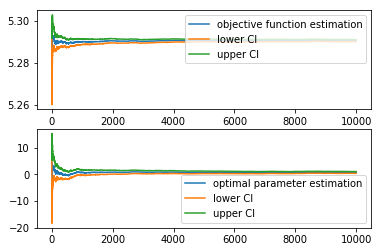

In [246]:
obj_exp, obj_CI, opt_exp, opt_CI = second_CV_Q3(2, .4, .1, .15, .25, .3, .01, .03, 200, .05, .05, 1, 10000)

In [247]:
print('Objective Function Confidence Interval: ',[obj_exp-obj_CI, obj_exp+obj_CI])

Objective Function Confidence Interval:  [5.29018702791844, 5.29112672261606]


In [248]:
print('Optimal Parameter Confidence Interval: ',[opt_exp-opt_CI, opt_exp+opt_CI])

Optimal Parameter Confidence Interval:  [0.3677306891742972, 1.0403225363687039]


Similar result! This is skewing our risky asset allocation even further to the lower end of the histogram.

<function matplotlib.pyplot.show(*args, **kw)>

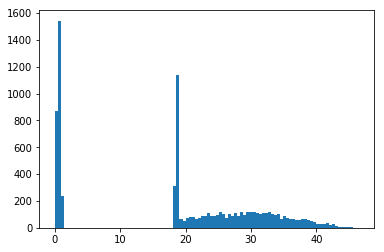

In [291]:
plt.hist(x2,bins=100)
plt.show

When we examine the histograms of the samples of the objective function and the optimal value, we can see that there are more samples clustered around the values that we computed as confidence intervals for our control variates. So maybe this actually was a good exercise in variance reduction after all.

It's an interesting result, because it's basically telling us that the marginal risk/reward for the risky asset isn't worth it.

We can compare the utility of a 100% allocation to the riskless security to the histogram of the maximized utility from our optimization routine

In [300]:
test = np.tile(np.log(200*np.exp(r)*1),1500)

<function matplotlib.pyplot.show(*args, **kw)>

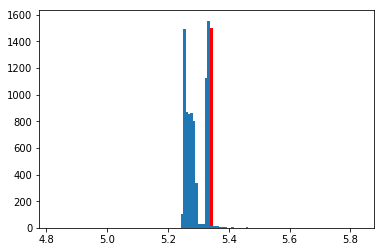

In [304]:
plt.hist(test, color='r', bins=50)
plt.hist(x1, bins=100)
plt.show

and it's on the upper bound of the histogram! Further showing the lack of a good risk-reward tradeoff.